# Building a House Price Predictor API

## 1. Import Data

In [1]:
! pip install pandas

In [2]:
!pip install scikit-learn xgboost dill

In [3]:
!pip install numpy
!pip install matplotlib

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
dataset = pd.read_csv('regressiondata.csv', index_col='ID')
dataset.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
0,2020.12,17.0,467.644775,4.0,5222.0,467104
1,2021.04,36.0,659.924963,3.0,5222.0,547714
2,2019.04,38.0,305.475941,7.0,5213.0,277232
3,2021.10,11.0,607.034754,5.0,5213.0,295958
4,2021.02,14.0,378.827222,5.0,5614.0,439963


## 2. Split Data to Prevent Snooping Bias

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
train, test = train_test_split(dataset, test_size = 0.3, random_state = 1234)

## 3. Exploratory Data Analysis

### Bird's Eye View

In [9]:
# Get datatypes of columns
train.dtypes

TransactionDate      float64
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode             float64
HousePrice            object
dtype: object

In [10]:
# Get info about the data
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6549 entries, 8450 to 8915
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionDate    6548 non-null   float64
 1   HouseAge           6546 non-null   float64
 2   DistanceToStation  6547 non-null   float64
 3   NumberOfPubs       6547 non-null   float64
 4   PostCode           6547 non-null   float64
 5   HousePrice         6544 non-null   object 
dtypes: float64(5), object(1)
memory usage: 358.1+ KB


In [11]:
# Create Summary Statistics
train.describe()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode
count,6548.000000,6546.000000,6547.000000,6.547000e+03,6547.000000
mean,2020.072389,17.375344,1091.759504,7.677828e+02,5294.499160
std,0.815922,11.469272,1270.038426,6.179430e+04,158.397718
min,2019.010000,0.000000,23.829424,0.000000e+00,5212.000000
25%,2019.100000,9.000000,268.649033,1.000000e+00,5213.000000
50%,2020.070000,15.000000,545.312168,4.000000e+00,5217.000000
75%,2021.040000,28.000000,1529.343484,6.000000e+00,5222.000000
max,2021.120000,43.000000,6486.256457,4.999999e+06,5614.000000


In [12]:
# Type cast incorrect datatypes to new datatypes
train['PostCode'] = train['PostCode'].astype(str)
train['TransactionDate'] = train['TransactionDate'].astype(str)

In [13]:
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice            object
dtype: object

In [14]:
# train['HousePrice'] = train['HousePrice'].astype(float)

In [15]:
# Create summary statistics for non-numeric values
train.describe(include='object')

,TransactionDate,PostCode,HousePrice
count,6549,6549,6544
unique,37,6,6496
top,2019.01,5212.0,290262
freq,212,1338,2


### Analyze Numerical Attributes

#### Plot Distributions

In [16]:
! pip install matplotlib seaborn

In [17]:
!pip show matplotlib seaborn

Name: matplotlib
Version: 3.6.3
Summary: Python plotting package
Home-page: https://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /Users/azamat/Desktop/Development/Full_Stack_Machine_Learning/fullstack/lib/python3.11/site-packages
Requires: contourpy, cycler, fonttools, kiwisolver, numpy, packaging, pillow, pyparsing, python-dateutil
Required-by: missingno, pandas-profiling, phik, seaborn, wordcloud, ydata-profiling
---
Name: seaborn
Version: 0.12.2
Summary: Statistical data visualization
Home-page: 
Author: 
Author-email: Michael Waskom <mwaskom@gmail.com>
License: 
Location: /Users/azamat/Desktop/Development/Full_Stack_Machine_Learning/fullstack/lib/python3.11/site-packages
Requires: matplotlib, numpy, pandas
Required-by: missingno, pandas-profiling, ydata-profiling


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
train.shape

(6549, 6)

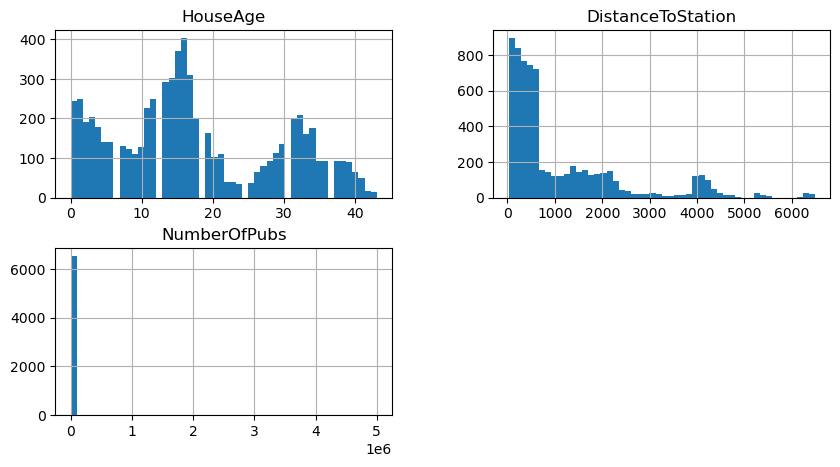

In [20]:
# Plot Distributions
train.hist(figsize=(10,5), bins=50)
plt.show()

#### Why house price is not Numeric?

In [21]:
# str => float
train['HousePrice'].astype(float)

ValueError: could not convert string to float: '??'

In [22]:
# filter dataset based on HousePrice == '??'
train[train['HousePrice'] == '??']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8718,2020.08,16.0,122.432508,5.0,5213.0,??


In [23]:
# Drop rows that equal '??'
train = train[train['HousePrice'] != '??']

In [24]:
# Double check if the row has been dropped
train[train['HousePrice']=='??']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,


In [25]:
# str => float
# Overwrite the house price column with float values
train['HousePrice'] = train['HousePrice'].astype(float)

In [26]:
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
dtype: object

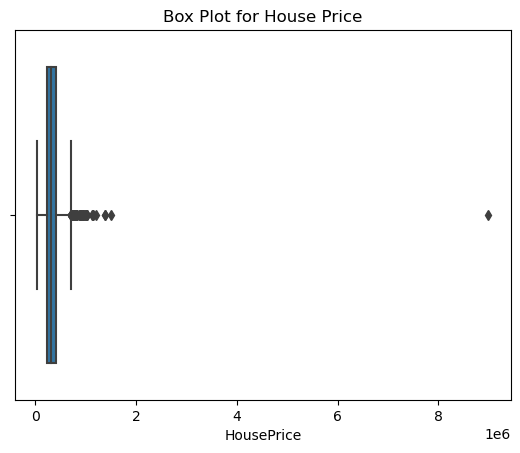

In [27]:
plt.title("Box Plot for House Price")
sns.boxplot(x=train['HousePrice'])
plt.show()

#### Drop Outlier

In [28]:
train.sort_values('HousePrice').tail(10)

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
9238,2019.11,10.0,169.424413,1.0,5222.0,1205920.0
149,2020.09,9.0,228.930655,1.0,5222.0,1374277.0
6066,2020.12,10.0,234.680008,1.0,5222.0,1374386.0
2749,2021.06,9.0,38.864337,1.0,5222.0,1504501.0
8445,2021.05,0.0,276.789752,9.0,5222.0,8989772.0
8103,2019.05,7.0,640.223538,10.0,5217.0,NaN
7673,nan,NaN,3830.892098,0.0,5217.0,NaN
32,2021.1,29.0,809.864711,8.0,5222.0,NaN
8112,2019.08,20.0,370.088151,NaN,nan,NaN


In [29]:
train = train.drop(8445)

In [30]:
train.sort_values('HousePrice').tail(10)

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
5091,2020.05,10.0,295.072723,1.0,5614.0,1151940.0
9238,2019.11,10.0,169.424413,1.0,5222.0,1205920.0
149,2020.09,9.0,228.930655,1.0,5222.0,1374277.0
6066,2020.12,10.0,234.680008,1.0,5222.0,1374386.0
2749,2021.06,9.0,38.864337,1.0,5222.0,1504501.0
8103,2019.05,7.0,640.223538,10.0,5217.0,NaN
7673,nan,NaN,3830.892098,0.0,5217.0,NaN
32,2021.1,29.0,809.864711,8.0,5222.0,NaN
8112,2019.08,20.0,370.088151,NaN,nan,NaN


In [31]:
# train = train.drop(13)
train.drop(13, inplace=True)

In [32]:
train.sort_values('NumberOfPubs').tail()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
3195,2020.11,32.0,324.371247,10.0,5614.0,488918.0
2996,2020.03,28.0,772.777219,10.0,5217.0,299235.0
5763,2020.02,33.0,326.339631,10.0,5222.0,555253.0
2416,2019.06,NaN,NaN,NaN,5222.0,268172.0
8112,2019.08,20.0,370.088151,NaN,nan,NaN


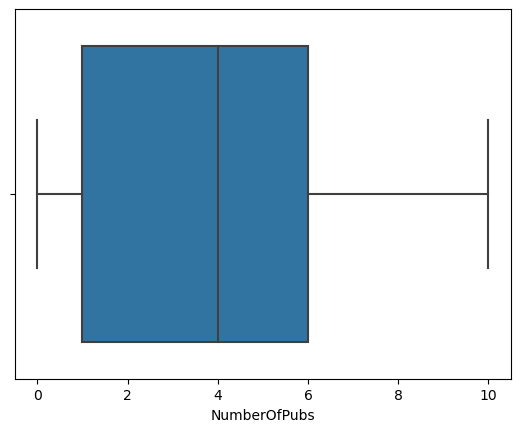

In [33]:
sns.boxplot(x = train['NumberOfPubs'])
plt.show()

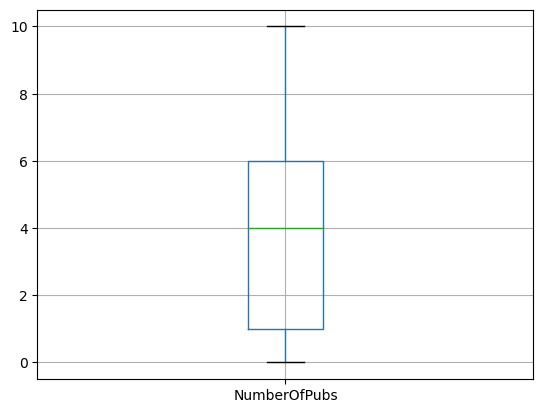

In [34]:
train.boxplot('NumberOfPubs')
plt.show()

### Analyse Categorical Variables

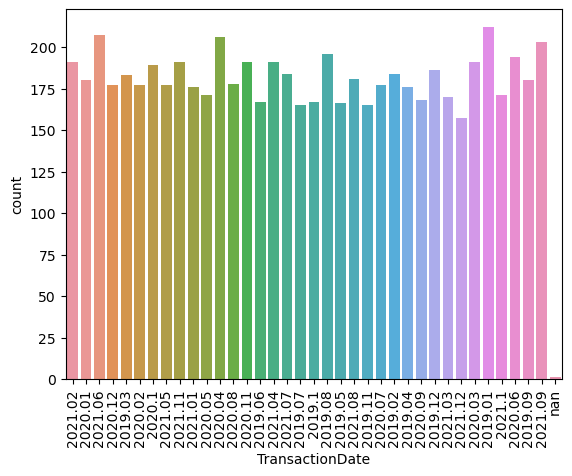

In [35]:
# create a counterplot for transaction date
plt.xticks(rotation=90)
sns.countplot(x='TransactionDate', data=train)
plt.show()

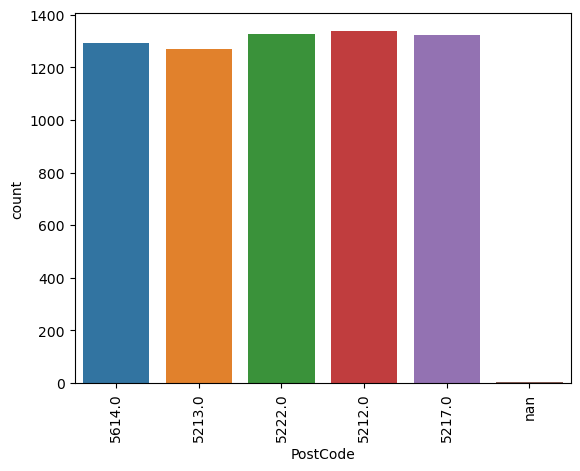

In [36]:
plt.xticks(rotation=90)
sns.countplot(x=train['PostCode'])
plt.show()

### Analyse Relationships between Numeric/Numeric

Calculate Pearsons Correlation

In [37]:
# calc pearsons corr (+1 = positive corr, -1 = negative corr)
train.select_dtypes(exclude='object').corr()

,HouseAge,DistanceToStation,NumberOfPubs,HousePrice
HouseAge,1.000000,0.034074,0.044189,-0.156693
DistanceToStation,0.034074,1.000000,-0.586704,-0.539859
NumberOfPubs,0.044189,-0.586704,1.000000,0.452309
HousePrice,-0.156693,-0.539859,0.452309,1.000000


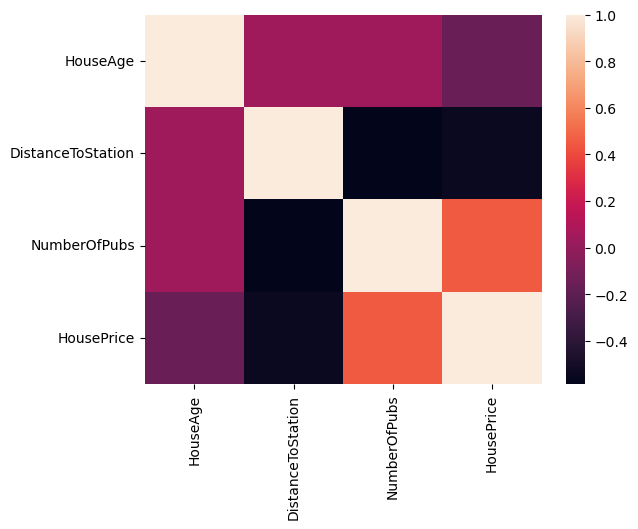

In [38]:
# viz corr with a heatmap
sns.heatmap(train.select_dtypes(exclude='object').corr())
plt.show()

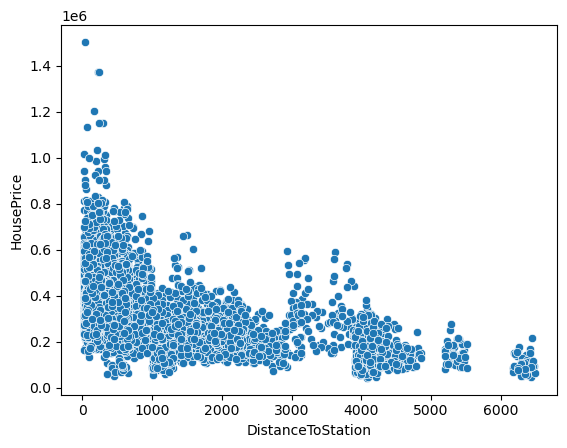

In [39]:
# create a scatter plot to see how the price decreases as distance increases
sns.scatterplot(x='DistanceToStation', y='HousePrice', data=train)
plt.show()

### Analyse relationships Categorical/Numeric

Is postcode driving value?

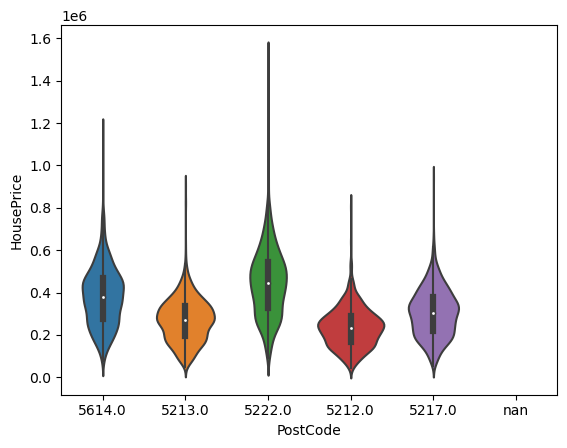

In [40]:
sns.violinplot(x='PostCode', y='HousePrice', data=train)
plt.show()

Working with dates

In [41]:
# check for nulls in a col
train[train['TransactionDate'].isnull()]

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,


In [42]:
# check for  a string exists in a col
train[train['TransactionDate']=='nan']

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
7673,nan,NaN,3830.892098,0.0,5217.0,NaN


In [43]:
# drop missing house prices
train = train[~train['HousePrice'].isnull()]  #train[(~train['HousePrice'].isnull()) & train['TransactionDate']=='nan']

In [44]:
train

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8450,2021.02,34.0,460.994365,8.0,5614.0,460286.0
5758,2020.01,17.0,614.851833,3.0,5213.0,253332.0
4030,2021.06,34.0,285.892687,9.0,5614.0,486532.0
8447,2020.12,0.0,195.213314,6.0,5222.0,595168.0
4370,2019.03,34.0,124.082230,8.0,5212.0,250495.0
...,...,...,...,...,...,...
664,2020.08,37.0,375.427313,1.0,5217.0,301492.0
7540,2020.08,34.0,114.362370,5.0,5212.0,174239.0
7221,2020.02,16.0,605.834036,2.0,5217.0,327666.0


In [45]:
int(train.iloc[0]['TransactionDate'][5:])

2

### Apply string transformation to Transaction Date

In [46]:
train['YearSold'] = train['TransactionDate'].apply(lambda x: x[:4]).astype(int)
train['MonthSold'] =train['TransactionDate'].apply(lambda x: x[5:]).astype(int)

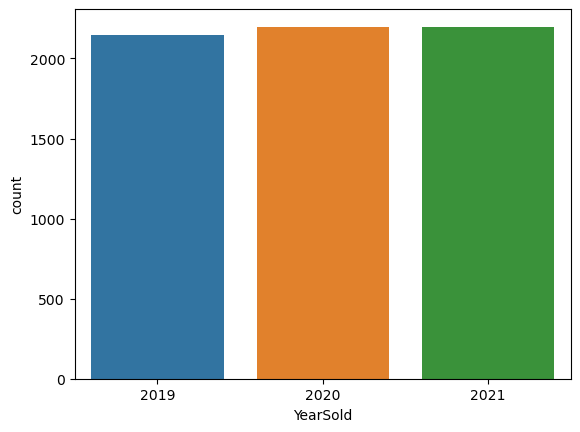

In [47]:
sns.countplot(x=train['YearSold'])
plt.show()

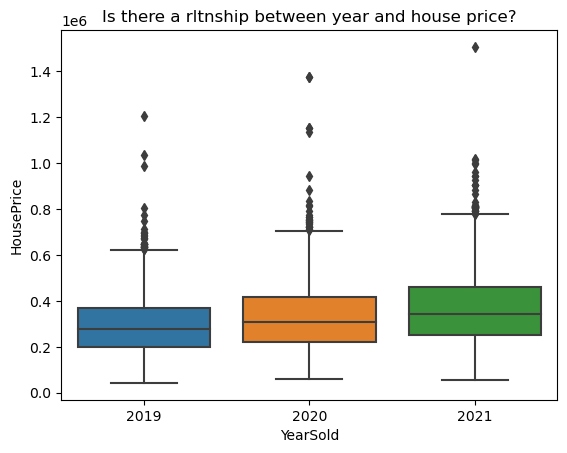

In [48]:
plt.title('Is there a rltnship between year and house price?')
sns.boxplot(x='YearSold', y='HousePrice', data=train)
plt.show()

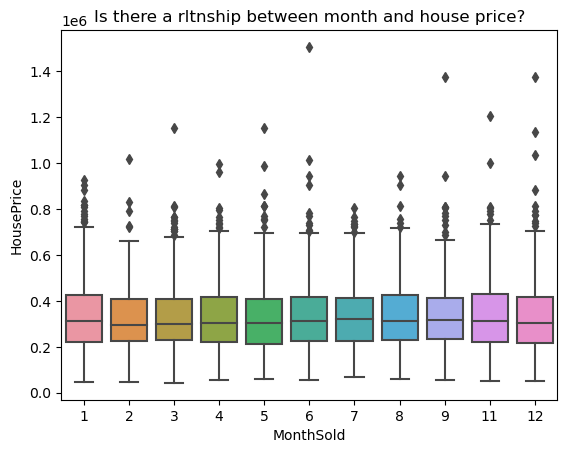

In [49]:
plt.title('Is there a rltnship between month and house price?')
sns.boxplot(x='MonthSold', y='HousePrice', data=train)
plt.show()

## 4. Data Preprocessing

### Build Preprocessing Function

In [50]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin

In [51]:
# Using Simple Imputer
imputer = SimpleImputer()
imputer.fit(train[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
imputer.transform(train[train['HouseAge'].isnull()][['HouseAge', 'DistanceToStation', 'NumberOfPubs']])

array([[  17.37972167, 1091.84711209,    4.0735474 ],
       [  17.37972167, 1091.84711209,    4.        ]])

In [52]:
# Using Standard Scaler
train[train['HouseAge'].isnull()][['HouseAge', 'DistanceToStation', 'NumberOfPubs']]
(16 - train['HouseAge'].mean()) / train['HouseAge'].std()

-0.12027904011738268

In [53]:
# Using One Hot Encoder
onehot = OneHotEncoder()
onehot.fit(train[['PostCode']])
onehot.transform(train[['PostCode']])
onehot.get_feature_names_out()

array(['PostCode_5212.0', 'PostCode_5213.0', 'PostCode_5217.0',
       'PostCode_5222.0', 'PostCode_5614.0'], dtype=object)

In [54]:
class Preprocessor(BaseEstimator, TransformerMixin):
    # train our custom preprocessors
    def fit(self, X, y=None):
        
        # Create and fit simple imputer
        self.imputer = SimpleImputer()
        self.imputer.fit(X[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
        
        # create and fit standard scaler
        self.scaler = StandardScaler()
        self.scaler.fit(X[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
        
        # create and fit one hot encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[['PostCode']])
        
        return self
        
        
    def transform(self, X):
        
        # apply simple imputer
        imputed_cols = self.imputer.transform(X[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
        onehot_cols = self.onehot.transform(X[['PostCode']])
        
        # copy the df
        transformed_df = X.copy()
        
        # apply year and month transformation
        transformed_df['Year'] = transformed_df['TransactionDate'].apply(lambda x: x[:4]).astype(int)
        transformed_df['Month'] = transformed_df['TransactionDate'].apply(lambda x: x[5:]).astype(int)
        transformed_df = transformed_df.drop('TransactionDate', axis=1)
        
        # apply transformed columns
        transformed_df[['HouseAge', 'DistanceToStation', 'NumberOfPubs']] = imputed_cols
        transformed_df[['HouseAge', 'DistanceToStation', 'NumberOfPubs']] = self.scaler.transform(transformed_df[['HouseAge', 'DistanceToStation', 'NumberOfPubs']])
        
        # drop existing post Code Column and replace it with one hot equiv
        transformed_df = transformed_df.drop('PostCode', axis=1)
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)
        
        return transformed_df

In [55]:
preproc = Preprocessor()

In [56]:
preproc.fit(train)

Preprocessor()

### Preview Preprocessed Data

In [57]:
preprocessed_df = preproc.transform(train.drop(['YearSold', 'MonthSold'], axis=1))
preprocessed_df.head()

,HouseAge,DistanceToStation,NumberOfPubs,HousePrice,Year,Month,PostCode_5212.0,PostCode_5213.0,PostCode_5217.0,PostCode_5222.0,PostCode_5614.0
ID,,,,,,,,,,,
8450,1.449005,-0.496716,1.328375,460286.0,2021,2,0,0,0,0,1
5758,-0.033105,-0.375573,-0.363196,253332.0,2020,1,0,1,0,0,0
4030,1.449005,-0.634586,1.666689,486532.0,2021,6,0,0,0,0,1
8447,-1.515216,-0.705984,0.651746,595168.0,2020,12,0,0,0,1,0
4370,1.449005,-0.761991,1.328375,250495.0,2019,3,1,0,0,0,0


In [58]:
preprocessed_df.dtypes

HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
HousePrice           float64
Year                   int64
Month                  int64
PostCode_5212.0        int64
PostCode_5213.0        int64
PostCode_5217.0        int64
PostCode_5222.0        int64
PostCode_5614.0        int64
dtype: object

In [59]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6541 entries, 8450 to 8915
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HouseAge           6541 non-null   float64
 1   DistanceToStation  6541 non-null   float64
 2   NumberOfPubs       6541 non-null   float64
 3   HousePrice         6541 non-null   float64
 4   Year               6541 non-null   int64  
 5   Month              6541 non-null   int64  
 6   PostCode_5212.0    6541 non-null   int64  
 7   PostCode_5213.0    6541 non-null   int64  
 8   PostCode_5217.0    6541 non-null   int64  
 9   PostCode_5222.0    6541 non-null   int64  
 10  PostCode_5614.0    6541 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 613.2 KB


### Clean up Analysis Features

In [60]:
train = train.drop(['YearSold', 'MonthSold'], axis=1)

In [61]:
train.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode,HousePrice
ID,,,,,,
8450,2021.02,34.0,460.994365,8.0,5614.0,460286.0
5758,2020.01,17.0,614.851833,3.0,5213.0,253332.0
4030,2021.06,34.0,285.892687,9.0,5614.0,486532.0
8447,2020.12,0.0,195.213314,6.0,5222.0,595168.0
4370,2019.03,34.0,124.082230,8.0,5212.0,250495.0


### Create X and y values

In [62]:
X_train = train.drop('HousePrice', axis=1)
y_train = train['HousePrice']

## 5. Modelling

### Import ML Dependencies

In [68]:
! conda install -c conda-forge xgboost

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
- DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/noarch/current_repodata.json HTTP/1.1" 304 0
^C
| 

In [69]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor

### Create Pipelines

In [70]:
pipelines = {
    'ridge': make_pipeline(Preprocessor(), Ridge()),
    'rf': make_pipeline(Preprocessor(), RandomForestRegressor()),
    'gb': make_pipeline(Preprocessor(), GradientBoostingRegressor()),
    'xg': make_pipeline(Preprocessor(), XGBRegressor())
}

In [71]:
pipelines['ridge']

Pipeline(steps=[('preprocessor', Preprocessor()), ('ridge', Ridge())])

### Create Tuning Grids

In [75]:
pipelines['ridge'].named_steps

{'preprocessor': Preprocessor(), 'ridge': Ridge()}

In [76]:
pipelines['ridge'].get_params()

{'memory': None,
 'steps': [('preprocessor', Preprocessor()), ('ridge', Ridge())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'ridge': Ridge(),
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__positive': False,
 'ridge__random_state': None,
 'ridge__solver': 'auto',
 'ridge__tol': 0.0001}

In [77]:
pipelines['rf'].get_params()

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('randomforestregressor', RandomForestRegressor())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'randomforestregressor': RandomForestRegressor(),
 'randomforestregressor__bootstrap': True,
 'randomforestregressor__ccp_alpha': 0.0,
 'randomforestregressor__criterion': 'squared_error',
 'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 1.0,
 'randomforestregressor__max_leaf_nodes': None,
 'randomforestregressor__max_samples': None,
 'randomforestregressor__min_impurity_decrease': 0.0,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 2,
 'randomforestregressor__min_weight_fraction_leaf': 0.0,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__n_jobs': None,
 'randomforestregressor__oob_score': False,
 'randomforestregressor__random_state': None,
 'randomforestregressor__verbose': 0,
 'randomforestregressor__warm_start': Fal

In [78]:
pipelines['gb'].get_params()

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('gradientboostingregressor', GradientBoostingRegressor())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'gradientboostingregressor': GradientBoostingRegressor(),
 'gradientboostingregressor__alpha': 0.9,
 'gradientboostingregressor__ccp_alpha': 0.0,
 'gradientboostingregressor__criterion': 'friedman_mse',
 'gradientboostingregressor__init': None,
 'gradientboostingregressor__learning_rate': 0.1,
 'gradientboostingregressor__loss': 'squared_error',
 'gradientboostingregressor__max_depth': 3,
 'gradientboostingregressor__max_features': None,
 'gradientboostingregressor__max_leaf_nodes': None,
 'gradientboostingregressor__min_impurity_decrease': 0.0,
 'gradientboostingregressor__min_samples_leaf': 1,
 'gradientboostingregressor__min_samples_split': 2,
 'gradientboostingregressor__min_weight_fraction_leaf': 0.0,
 'gradientboostingregressor__n_estimators': 100,
 'gradientboostingregressor__n_iter_no_change': None,
 'g

In [79]:
pipelines['xg'].get_params()

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('xgbregressor',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=None, ...))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'xgbregressor': XGBRegressor(base_score=None, booster=None, callbacks=None,
             

In [80]:
ridgemodel = Ridge()

In [81]:
ridgemodel.alpha

1.0

In [82]:
pipelines['ridge']['ridge'].alpha

1.0

In [83]:
grid = {
    'ridge': {'ridge__alpha': [0.05, 0.25, 0.5, 1.0]},
    'rf': {
        'randomforestregressor__n_estimators':[100, 200, 300],
        'randomforestregressor__max_depth':[5, 6, 7, None]
    },
    'gb': {
        'gradientboostingregressor__n_estimators':[100, 200, 300],
        'gradientboostingregressor__max_depth':[5, 6, 7, None]
    },
    'xg': {
        'xgbregressor__n_estimators':[100, 200, 300],
        'xgbregressor__max_depth':[5, 6, 7, None]
    }
}

### Train Models and Perform HPO

In [84]:
from sklearn.model_selection import GridSearchCV

In [85]:
fit_models = {}
for algo, pipeline in pipelines.items():
    try:
        print(algo)
        model = GridSearchCV(pipeline, grid[algo], n_jobs=1, cv=10, scoring='r2')
        model.fit(X_train, y_train)
        fit_models[algo] = model
    except Exception as e:
        pritn('*************\nModel {} had an error {}\n*************'.format(algo, e))

ridge
rf
gb
xg


In [86]:
fit_models

{'ridge': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                        ('ridge', Ridge())]),
              n_jobs=1, param_grid={'ridge__alpha': [0.05, 0.25, 0.5, 1.0]},
              scoring='r2'),
 'rf': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                        ('randomforestregressor',
                                         RandomForestRegressor())]),
              n_jobs=1,
              param_grid={'randomforestregressor__max_depth': [5, 6, 7, None],
                          'randomforestregressor__n_estimators': [100, 200,
                                                                  300]},
              scoring='r2'),
 'gb': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('preprocessor', Preprocessor()),
                                        ('gradientboostingregressor',
                                        

## 6. Evaluate Models

### Import Evaluation Metrics

In [87]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

### Preprocess Test Set for Predictions

##### Look for Nulls

In [88]:
## look for null in test dataset
test.isnull().sum()

TransactionDate      1
HouseAge             1
DistanceToStation    0
NumberOfPubs         0
PostCode             0
HousePrice           2
dtype: int64

In [89]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2807 entries, 7857 to 641
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TransactionDate    2806 non-null   float64
 1   HouseAge           2806 non-null   float64
 2   DistanceToStation  2807 non-null   float64
 3   NumberOfPubs       2807 non-null   float64
 4   PostCode           2807 non-null   float64
 5   HousePrice         2805 non-null   object 
dtypes: float64(5), object(1)
memory usage: 153.5+ KB


In [90]:
test = test[~test.HousePrice.isnull()]

In [91]:
test.isnull().sum()

TransactionDate      0
HouseAge             1
DistanceToStation    0
NumberOfPubs         0
PostCode             0
HousePrice           0
dtype: int64

##### Check Dtypes

In [92]:
test.dtypes

TransactionDate      float64
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode             float64
HousePrice            object
dtype: object

In [93]:
train.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
dtype: object

In [94]:
# Fix dtypes in test df
test = test[test['HousePrice']!='??']
# can use array.ColName if there are not spaces
test['HousePrice'] = test.HousePrice.astype(float)
test['TransactionDate'] = test.TransactionDate.astype(str)
test['PostCode'] = test.PostCode.astype(str)

In [95]:
test.dtypes

TransactionDate       object
HouseAge             float64
DistanceToStation    float64
NumberOfPubs         float64
PostCode              object
HousePrice           float64
dtype: object

##### Create X_test and y_test

In [96]:
X_test = test.drop('HousePrice', axis=1)
y_test = test['HousePrice']

In [97]:
X_test.head()

,TransactionDate,HouseAge,DistanceToStation,NumberOfPubs,PostCode
ID,,,,,
7857,2021.11,0.0,267.000535,6.0,5222.0
1641,2021.04,12.0,500.080510,5.0,5212.0
3620,2019.07,14.0,4024.663391,0.0,5614.0
2820,2020.09,18.0,568.954185,4.0,5614.0
1572,2020.07,11.0,44.210016,1.0,5614.0


In [98]:
y_test.head()

ID
7857    919497.0
1641    283680.0
3620    135818.0
2820    468742.0
1572    311065.0
Name: HousePrice, dtype: float64

### Calculate Regression Metrics

In [99]:
for algo, model in fit_models.items():
    # print(algo)
    yhat = model.predict(X_test)
    r2 = r2_score(y_test, yhat)
    mae = mean_absolute_error(y_test, yhat)
    mse = mean_squared_error(y_test, yhat)
    print(f'{algo}: \n\tR2 Score - {r2}\n\tMAE - {mae}\n\tMSE - {mse}')

ridge: 
	R2 Score - 0.6691443155811749
	MAE - 62578.08779739718
	MSE - 7311888534.58613
rf: 
	R2 Score - 0.8204176370495413
	MAE - 44446.21349268641
	MSE - 3968758230.5798564
gb: 
	R2 Score - 0.863311212793568
	MAE - 38676.941744425196
	MSE - 3020813070.6196394
xg: 
	R2 Score - 0.853617617693814
	MAE - 39618.537530937836
	MSE - 3235040875.0876684


### Make Predictions

In [100]:
model = fit_models['gb']

In [101]:
yhat = model.predict(X_test)

In [102]:
results_df = y_test.to_frame()
results_df['yhat'] = yhat
results_df['delta'] = results_df.HousePrice.astype(float) - results_df.yhat

In [103]:
results_df.to_csv('results.csv')

### Explain Model

#### Calculate Feature Importance

In [104]:
model.best_estimator_

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=5, n_estimators=300))])

In [105]:
model.best_estimator_['gradientboostingregressor']

GradientBoostingRegressor(max_depth=5, n_estimators=300)

In [106]:
model.best_estimator_['gradientboostingregressor'].feature_importances_

array([0.12757451, 0.4673872 , 0.04494744, 0.05178395, 0.00636231,
       0.02393243, 0.00654418, 0.00965595, 0.17484228, 0.08696976])

In [107]:
sum(model.best_estimator_['gradientboostingregressor'].feature_importances_)

1.0

In [108]:
ensemble = model.best_estimator_['gradientboostingregressor']

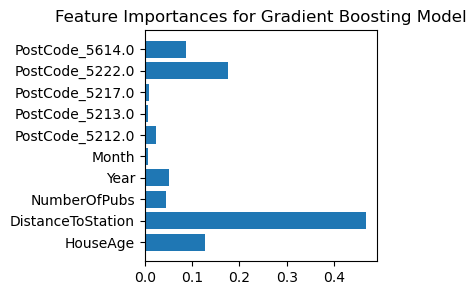

In [109]:
plt.figure(figsize=(3,3))
plt.title('Feature Importances for Gradient Boosting Model')
plt.barh(ensemble.feature_names_in_, ensemble.feature_importances_)
plt.show()

#### Calculate Feature Importance for All Models

In [110]:
import numpy as np

In [111]:
feature_importances = {}
for algo, pipeline in fit_models.items():
    if algo == 'ridge':
        # calculate alternate metric
        coef_ = pipeline.best_estimator_[1].coef_
        feature_importances[algo] = np.square(coef_) / np.sum(np.square(coef_))
    else:
        feature_importances[algo] = pipeline.best_estimator_[1].feature_importances_

In [112]:
feature_importances

{'ridge': array([1.64842453e-02, 1.01874497e-01, 3.10969377e-02, 3.86862977e-02,
        5.94596526e-06, 2.25704876e-01, 9.47271060e-02, 1.69412578e-02,
        3.92285970e-01, 8.21928660e-02]),
 'rf': array([0.13611639, 0.44663197, 0.05599787, 0.05121858, 0.0344733 ,
        0.00886864, 0.0027826 , 0.01187162, 0.16601218, 0.08602684]),
 'gb': array([0.12757451, 0.4673872 , 0.04494744, 0.05178395, 0.00636231,
        0.02393243, 0.00654418, 0.00965595, 0.17484228, 0.08696976]),
 'xg': array([0.03207528, 0.07127062, 0.02292063, 0.05411822, 0.00475283,
        0.09275293, 0.02268689, 0.04478648, 0.41193107, 0.24270506],
       dtype=float32)}

In [113]:
ensemble.feature_names_in_

array(['HouseAge', 'DistanceToStation', 'NumberOfPubs', 'Year', 'Month',
       'PostCode_5212.0', 'PostCode_5213.0', 'PostCode_5217.0',
       'PostCode_5222.0', 'PostCode_5614.0'], dtype=object)

In [114]:
importance_df = pd.DataFrame(feature_importances, index=ensemble.feature_names_in_)
importance_df

,ridge,rf,gb,xg
HouseAge,0.016484,0.136116,0.127575,0.032075
DistanceToStation,0.101874,0.446632,0.467387,0.071271
NumberOfPubs,0.031097,0.055998,0.044947,0.022921
Year,0.038686,0.051219,0.051784,0.054118
Month,0.000006,0.034473,0.006362,0.004753
PostCode_5212.0,0.225705,0.008869,0.023932,0.092753
PostCode_5213.0,0.094727,0.002783,0.006544,0.022687
PostCode_5217.0,0.016941,0.011872,0.009656,0.044786
PostCode_5222.0,0.392286,0.166012,0.174842,0.411931
PostCode_5614.0,0.082193,0.086027,0.086970,0.242705


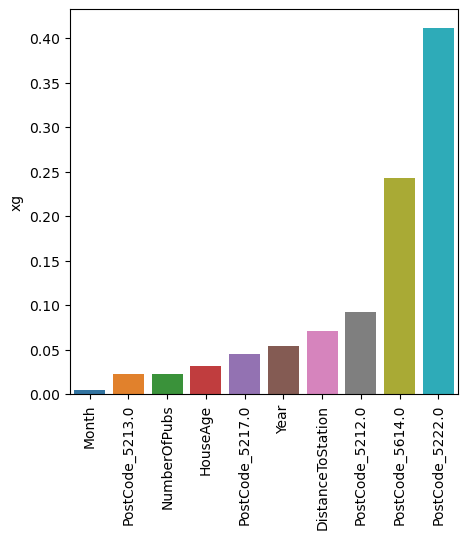

In [115]:
plt.figure(figsize=(5,5))
model_name = 'xg'
sorted_imp = importance_df.sort_values(model_name)
sns.barplot(x=sorted_imp.index, y=model_name, data=sorted_imp)
plt.xticks(rotation = 90)
plt.show()

#### Plot Trees

In [116]:
!pip install graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.4 MB/s eta 0:00:00


In [117]:
from sklearn.tree import plot_tree
import xgboost as xgb
from matplotlib.pylab import rcParams

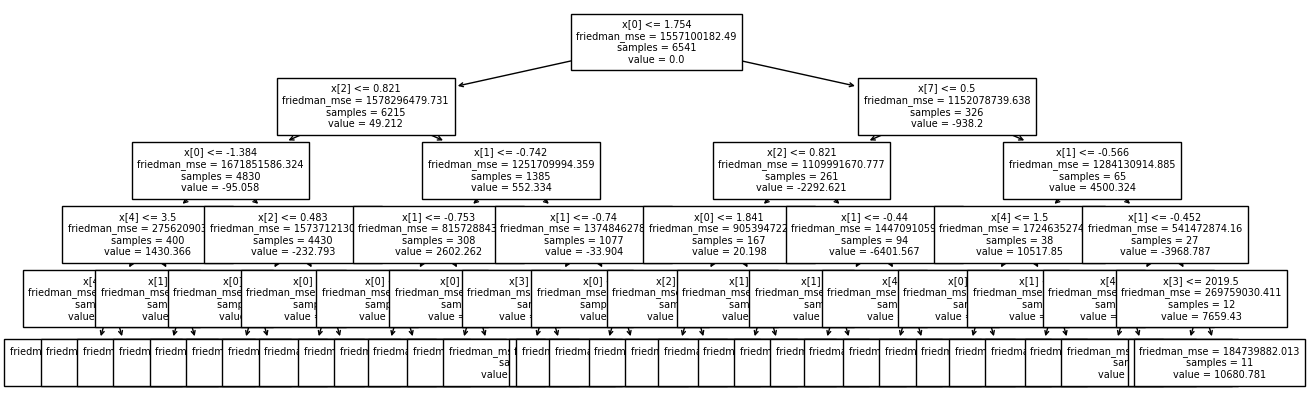

In [118]:
# plot trees for gradient boosted model
plt.figure(figsize=(15,5))
plot_tree(ensemble.estimators_[299,0], fontsize=7)
plt.show()

ImportError: You must install graphviz to plot tree

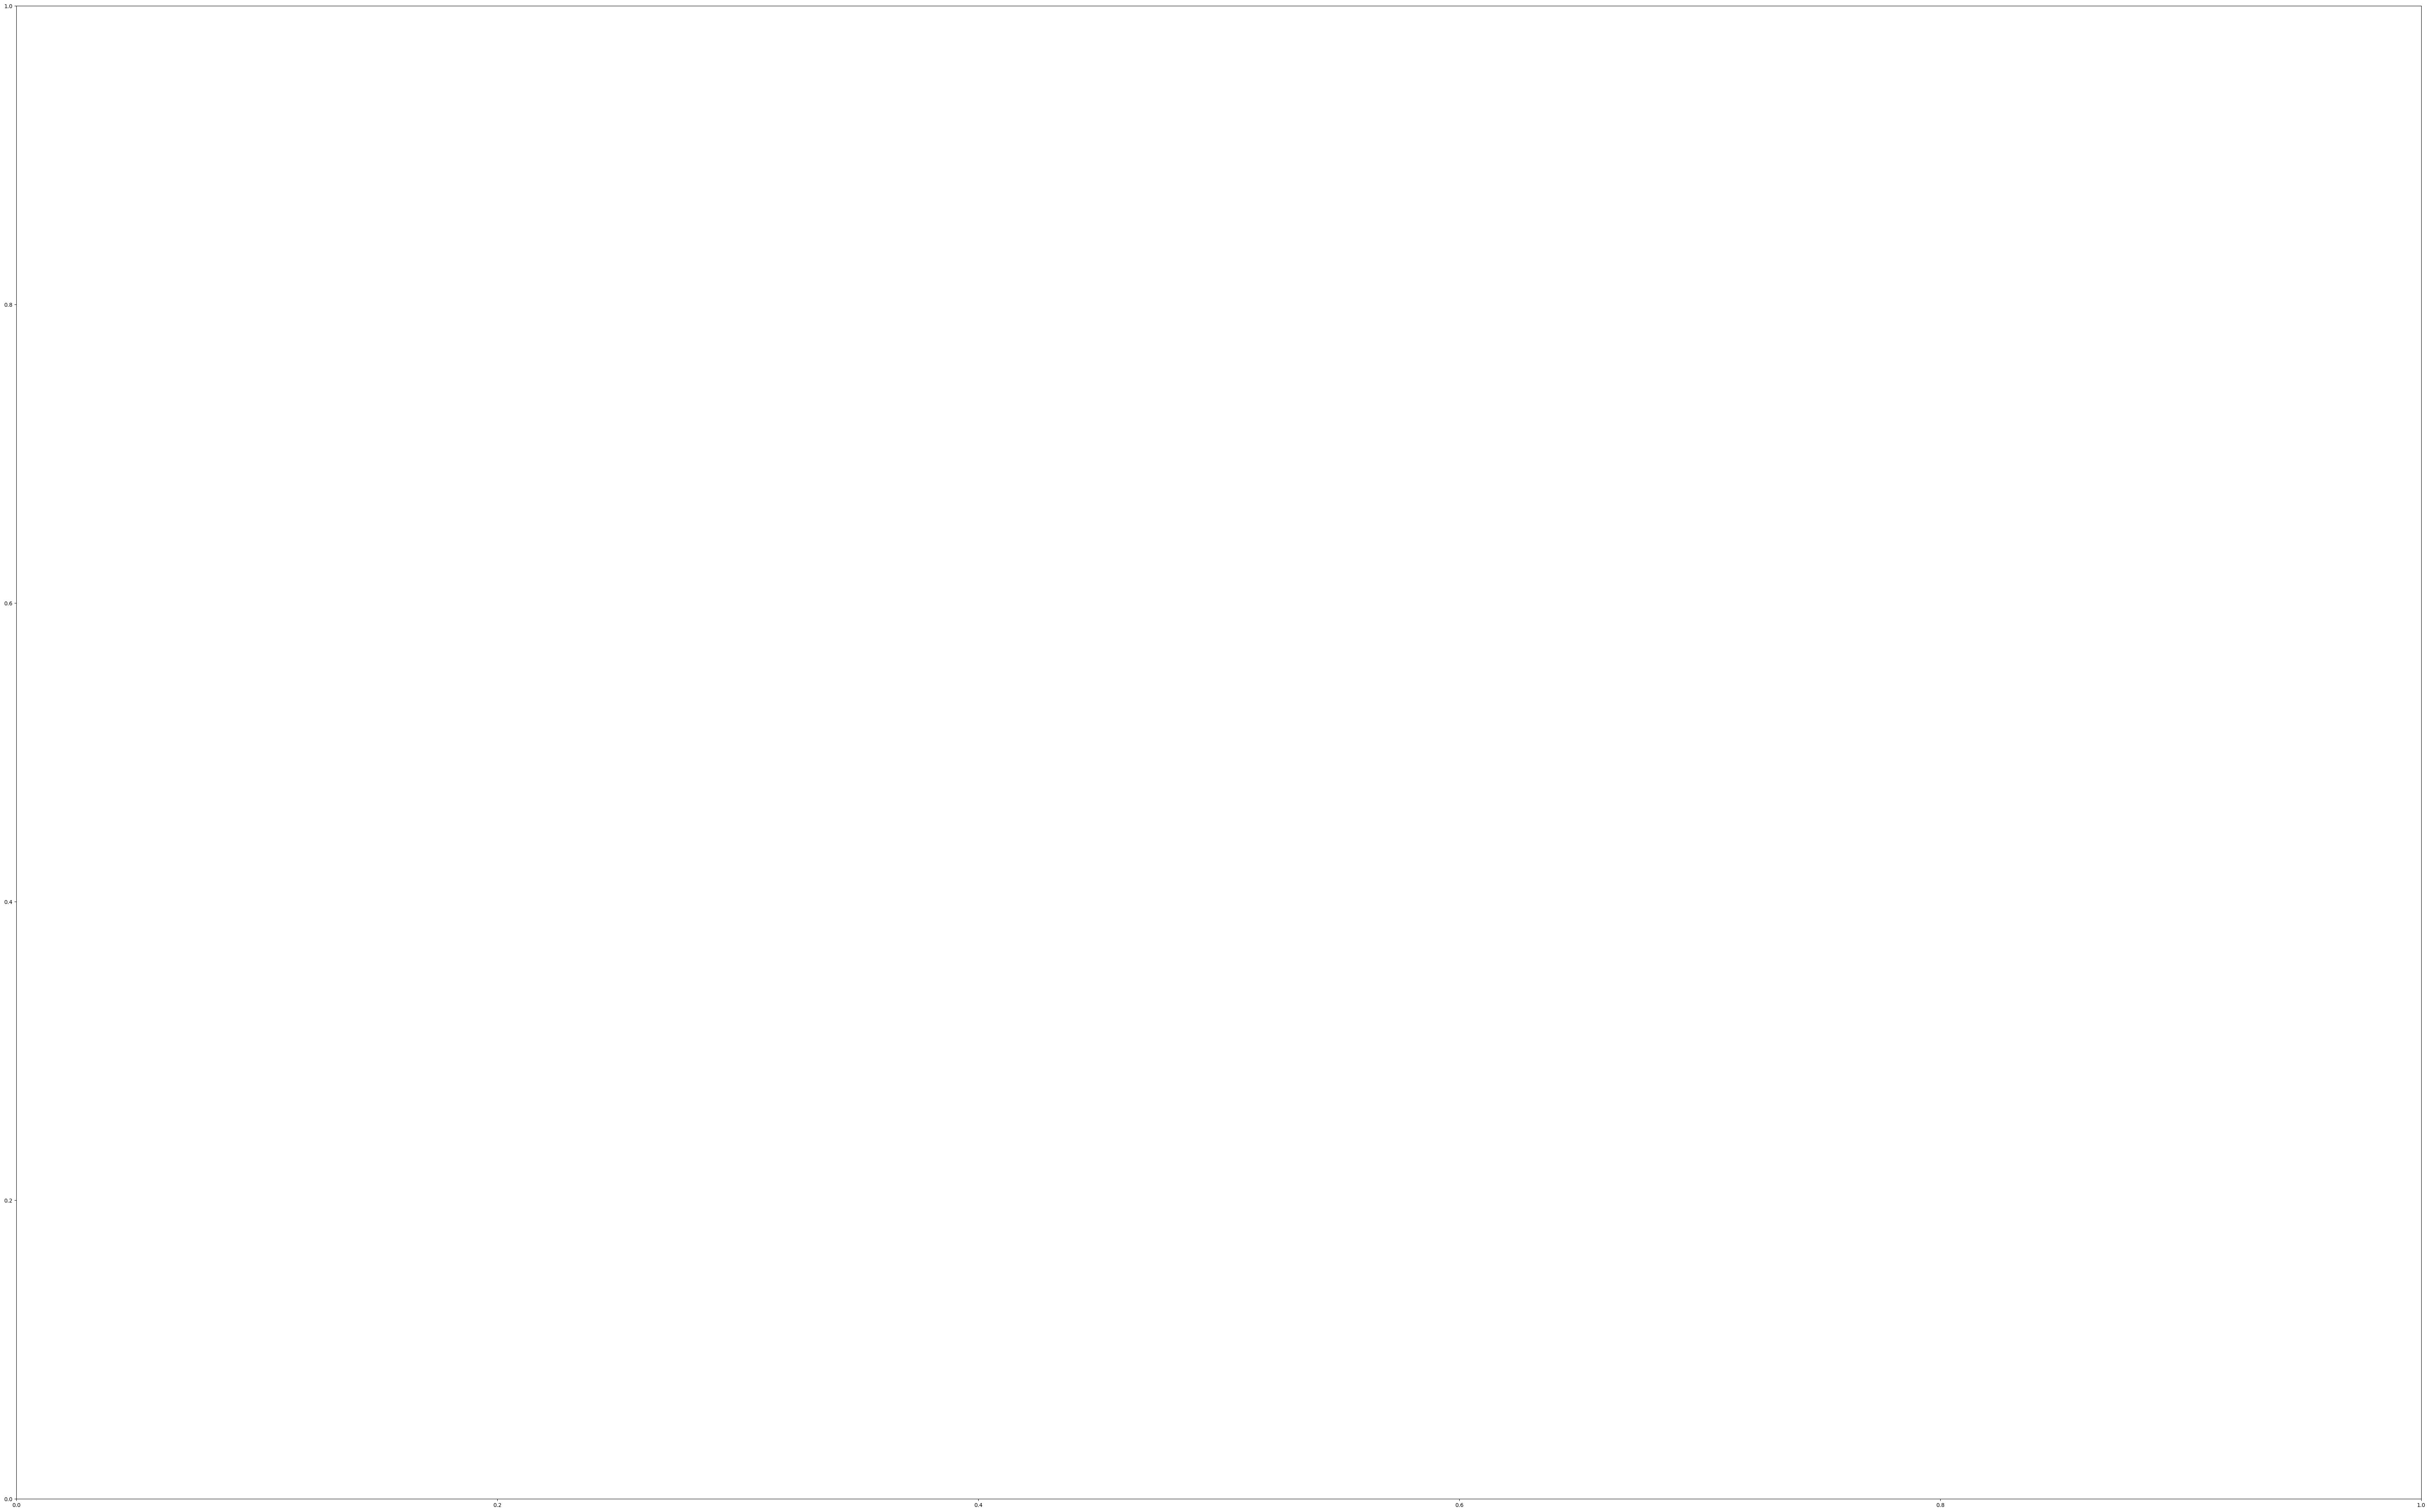

In [120]:
rcParams['figure.figsize'] = 80, 50
xgb.plot_tree(fit_models['xg'].best_estimator_[1])
plt.show()

## 7. Save Model

In [144]:
import dill, pickle

In [145]:
model = fit_models['gb']

In [152]:
# save model using dill
with open('gb.pkl', 'wb') as f:
    dill.dump(model,f)

In [154]:
with open('gb.pkl', 'rb') as f:
    reloaded_model = dill.load(f)

In [155]:
reloaded_model.predict(X_test)

array([660072.29726806, 289177.79297644, 166619.49465334, ...,
       392935.05936691, 737461.9967578 , 411115.3101777 ])

In [149]:
X_test.loc[0].to_json()

'{"TransactionDate":"2020.12","HouseAge":17.0,"DistanceToStation":467.6447748,"NumberOfPubs":4.0,"PostCode":"5222.0"}'

In [150]:
reloaded_model.predict(X_test)

array([660072.29726806, 289177.79297644, 166619.49465334, ...,
       392935.05936691, 737461.9967578 , 411115.3101777 ])